In [1]:
%cd C:\Users\yukir\Documents\GitHub\sign_detection\py

C:\Users\yukir\Documents\GitHub\sign_detection\py


In [2]:
from basic_preprocessing import *
from deeplearning_check import *

gpu_check()
set_global_determinism(seed=SEED)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1023831462717275812
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14781225486850799143
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1849519540732419686
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2409810294356221457
physical_device_desc: "device: XLA_GPU device"
]
tf 2.2.0
keras 2.3.0-tf


In [3]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Datasets\[0823]output

C:\Users\yukir\Documents\Monicas_workspace\Datasets\[0823]output


In [4]:
test_dir = "test"

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(200, 200), color_mode='rgb')

input_tensor = Input(shape=(200, 200, 3), dtype='float32', name='input')

Found 72 images belonging to 4 classes.


In [13]:
%cd C:\Users\yukir\Documents\Monicas_workspace\Sign detection\★meaningful★\model_weight\0.889\

C:\Users\yukir\Documents\Monicas_workspace\Sign detection\★meaningful★\model_weight\0.889


In [7]:
def create_model():
    optimizer = Adam()
    
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = tf.keras.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(Flatten())
    additional_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2048, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(4, activation='softmax'))
    

    additional_model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics=['acc'])

    
    return additional_model

In [8]:
test_model = create_model()
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              75501568  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 100,709,188
Trainable params: 85,994,500
Non-trainable params: 14,714,688
__________________________________

In [9]:
test_model.load_weights("C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\★meaningful★\\model_weight\\0.889\\[0823](0.889)vgg_new_cb.h5")

###### https://lynnshin.tistory.com/25

In [14]:
from sklearn.metrics import confusion_matrix
# rest test_generator
test_generator.reset()

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


predictions = test_model.predict_generator(test_generator)

# Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)
# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print(report)    

[0 3 3 3 3 2 2 0 2 0 0 2 0 0 2 0 0 3 2 0 3 3 2 0 0 1 0 2 2 0 1 0 0 0 0 0 0
 2 2 0 2 0 2 3 1 0 1 0 1 2 0 0 1 1 0 0 1 0 3 3 1 2 1 0 3 0 0 2 0 3 1 3]
Confusion Matrix
[[13  2  9  7]
 [ 8  0  3  0]
 [ 7  6  2  3]
 [ 4  3  2  3]]
              precision    recall  f1-score   support

     fragile       0.41      0.42      0.41        31
      handle       0.00      0.00      0.00        11
          up       0.12      0.11      0.12        18
         wet       0.23      0.25      0.24        12

    accuracy                           0.25        72
   macro avg       0.19      0.20      0.19        72
weighted avg       0.24      0.25      0.25        72



#### test set확인

In [24]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
    file_list = file_list[1:]
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

test_path= "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\[0823]output\\test\\fragile\\"

file_list = file_list(test_path)

results={
   0:'fragile',
   1:'handle',
   2:'up',
   3:'wet'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((200,200))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=test_model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    fragile_df = pd.DataFrame(answer, columns = columns )
fragile_df.head()

,file_name,label,class
0,fragile_resized_105.jpg,0,fragile
1,fragile_resized_109.jpg,0,fragile
2,fragile_resized_110.jpg,1,handle
3,fragile_resized_112.jpg,1,handle
4,fragile_resized_115.jpg,0,fragile


In [29]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
#     file_list = file_list[
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

test_path= "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\[0823]output\\test\\up\\"

file_list = file_list(test_path)

results={
   0:'fragile',
   1:'handle',
   2:'up',
   3:'wet'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((200,200))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=test_model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    up_df = pd.DataFrame(answer, columns = columns )
up_df.head()

,file_name,label,class
0,up_resized_1.jpg,2,up
1,up_resized_105.jpg,1,handle
2,up_resized_107.jpg,2,up
3,up_resized_118.jpg,2,up
4,up_resized_120.jpg,0,fragile


In [30]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
#     file_list = file_list[1:]
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

test_path= "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\[0823]output\\test\\handle\\"

file_list = file_list(test_path)

results={
   0:'fragile',
   1:'handle',
   2:'up',
   3:'wet'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((200,200))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=test_model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    handle_df = pd.DataFrame(answer, columns = columns )
handle_df.head()

,file_name,label,class
0,handle_resized_0.jpg,1,handle
1,handle_resized_16.jpg,1,handle
2,handle_resized_17.jpg,1,handle
3,handle_resized_24.jpg,1,handle
4,handle_resized_40.jpg,1,handle


In [34]:
def get_file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
#     file_list = file_list[1:]
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

test_path= "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\[0823]output\\test\\wet\\"

file_list = file_list(test_path)

results={
   0:'fragile',
   1:'handle',
   2:'up',
   3:'wet'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((200,200))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=test_model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    wet_df = pd.DataFrame(answer, columns = columns )
wet_df.head()

,file_name,label,class
0,wet_resized_0.jpg,3,wet
1,wet_resized_108.jpg,3,wet
2,wet_resized_109.jpg,3,wet
3,wet_resized_15.jpg,3,wet
4,wet_resized_31.jpg,3,wet


In [45]:
#total
total_df = pd.concat([fragile_df, up_df, wet_df, handle_df])

In [53]:
def slice_name(i):
#     classes = ''
    i = i.split('_')[0]
    return i

In [47]:
total_df.head()

,file_name,label,class
0,fragile_resized_105.jpg,0,fragile
1,fragile_resized_109.jpg,0,fragile
2,fragile_resized_110.jpg,1,handle
3,fragile_resized_112.jpg,1,handle
4,fragile_resized_115.jpg,0,fragile


In [54]:
total_df['org_answer'] = total_df['file_name'].apply(lambda x: slice_name(x))
total_df.head()

,file_name,label,class,org_answer
0,fragile_resized_105.jpg,0,fragile,fragile
1,fragile_resized_109.jpg,0,fragile,fragile
2,fragile_resized_110.jpg,1,handle,fragile
3,fragile_resized_112.jpg,1,handle,fragile
4,fragile_resized_115.jpg,0,fragile,fragile


In [55]:
total_df['eval'] = (total_df['class'] == total_df['org_answer'])

In [58]:
filter_con = total_df['eval']==False
false_df = total_df[filter_con]
false_df

,file_name,label,class,org_answer,eval
2,fragile_resized_110.jpg,1,handle,fragile,False
3,fragile_resized_112.jpg,1,handle,fragile,False
18,fragile_resized_278.jpg,2,up,fragile,False
23,fragile_resized_36.jpg,1,handle,fragile,False
25,fragile_resized_43.jpg,1,handle,fragile,False
27,fragile_resized_77.jpg,1,handle,fragile,False
1,up_resized_105.jpg,1,handle,up,False
4,up_resized_120.jpg,0,fragile,up,False
5,up_resized_133.jpg,0,fragile,up,False
7,up_resized_16.jpg,0,fragile,up,False


In [65]:
72/14

5.142857142857143

#### test_generator false set

In [70]:
test_path = 'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\[0823]output\\test\\'
fragile_path = test_path+'fragile\\'
up_path = test_path+'up\\'
wet_path = test_path+'wet\\'
handle_path = test_path+'handle\\'

In [78]:
name_file = false_df.file_name.tolist()
fragile_false = name_file[:6]
up_false = name_file[6:]

In [ ]:
false_list = []
for i in fragile_false:
    i = fragile_path+i
    false_list.append(i)
for i in up_false:
    i = up_path+i
    false_list.append(i)

In [98]:
def direct_show(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (4,4))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

In [ ]:
plt.figure(figsize=(4,4))
for i in false_list:
    direct_show(i)

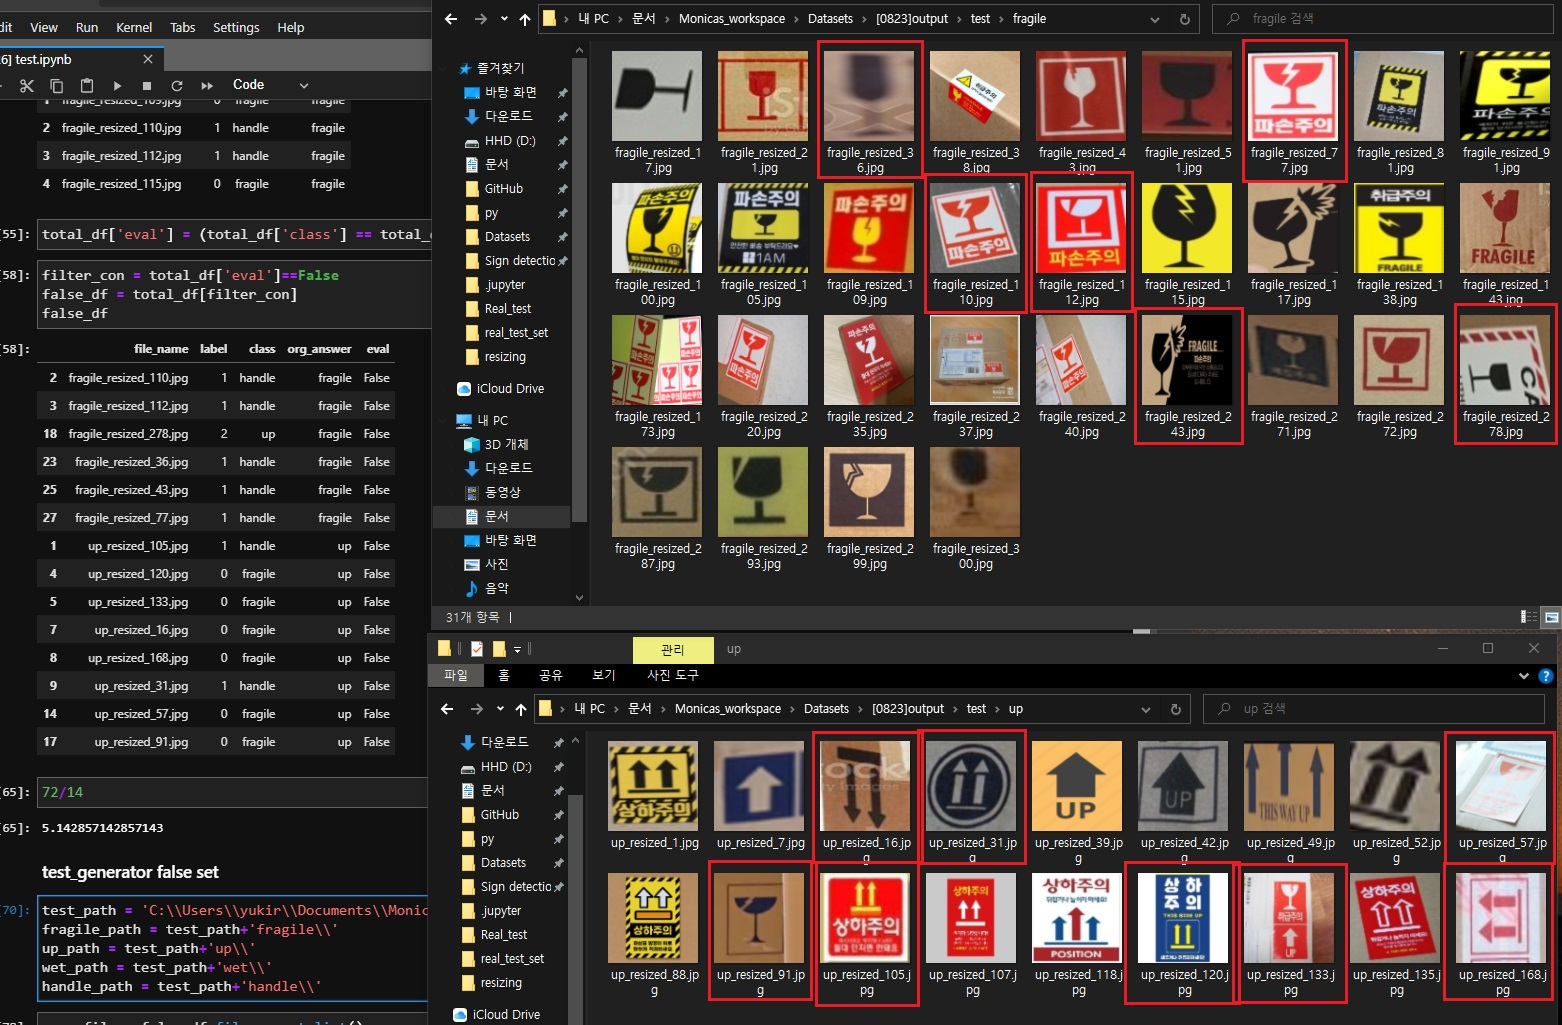

In [100]:
from IPython.display import Image
Image("C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0827 test.JPG")

#### real_test_set 이미지 확인

In [32]:
def file_list(path):
    file_list = os.listdir(path)
    file_list.sort()
#     file_list = file_list[1:]
    list_file = []
    for i in file_list:
        list_file.append(path+i)
    return list_file

path ='C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\Real_test\\real_test_set\\'

file_list = file_list(path)

results={
   0:'fragile',
   1:'handle',
   2:'up',
   3:'wet'
}
columns =['file_name', 'label', 'class']
answer = []
for i in file_list:
    im=Image.open(i)
    # the input image is required to be in the shape of dataset, i.e (32,32,3)
    i= i.split('\\')[-1]
    im=im.resize((200,200))
    im=np.expand_dims(im,axis=0) #차원으로 분리
    im=np.array(im)
    pred=test_model.predict_classes([im])[0]
    answer.append([i, pred, results[pred]])
    answer_df = pd.DataFrame(answer, columns = columns )
answer_df.head()

,file_name,label,class
0,box_false(2).JPG,0,fragile
1,box_false.JPG,0,fragile
2,box_fragile.JPG,0,fragile
3,cold.JPG,2,up
4,cut_ (1).jpg,0,fragile


In [101]:
answer_df

,file_name,label,class
0,box_false(2).JPG,0,fragile
1,box_false.JPG,0,fragile
2,box_fragile.JPG,0,fragile
3,cold.JPG,2,up
4,cut_ (1).jpg,0,fragile
5,cut_ (2).JPG,0,fragile
6,cut_ (3).jpg,0,fragile
7,cut_ (4).JPG,0,fragile
8,cut_ (5).JPG,1,handle
9,cut_ (6).JPG,1,handle


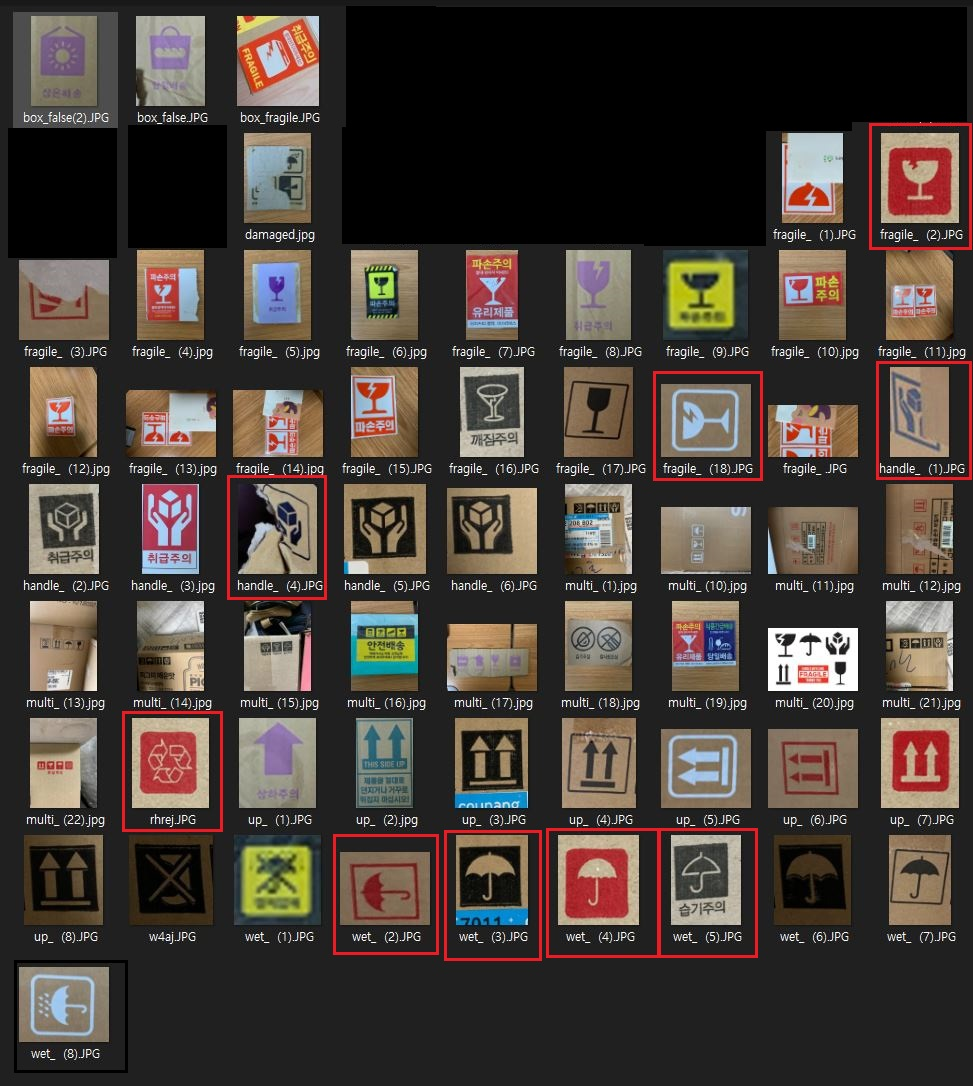

In [102]:
Image("C:\\Users\\yukir\\Documents\\Monicas_workspace\\Datasets\\0827 real_Test.JPG")